In [3]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# Checking the dataset
train_data.head()
# Print the number of missing values in each column
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Data preprocessing - Updated version
train_data = train_data.copy()  # Create a copy to avoid SettingWithCopyWarning
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')

# Print the number of missing values in each column
train_data.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [7]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

def feature_engineering(data, is_train=True):
    """
    Apply feature engineering to either train or test data
    is_train: boolean to indicate if this is training data
    """
    le = LabelEncoder()

    # Extract title from Name
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # 1. Family Size and Is_Alone features
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # 2. Fare Binning
    # Handle missing Fare in test data
    data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
    data['FareBin'] = pd.qcut(data['Fare'], 4, labels=['Low', 'Mid', 'Mid-High', 'High'])
    data['FareBin'] = le.fit_transform(data['FareBin'])

    # 3. Age Binning
    # Handle missing Age
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    data['AgeBin'] = pd.cut(data['Age'], 
                           bins=[0, 12, 20, 40, 60, np.inf], 
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    data['AgeBin'] = le.fit_transform(data['AgeBin'])

    # 4. Create Cabin Feature
    data['Cabin'] = data['Cabin'].fillna('Unknown')
    data['Deck'] = data['Cabin'].str[0]
    data['Deck'] = le.fit_transform(data['Deck'])

    # 5. Name Length
    data['NameLength'] = data['Name'].apply(len)

    # 6. Ticket Feature
    def clean_ticket(ticket):
        if len(ticket.split(' ')) > 1:
            return ''.join(ticket.split(' ')[:-1]).replace('.','').replace('/','').upper()
        else:
            return 'XXX'
            
    def extract_ticket_number(ticket):
        number = ticket.split(' ')[-1]
        try:
            return int(number)
        except ValueError:
            return -1

    data['TicketPrefix'] = data['Ticket'].apply(clean_ticket)
    data['TicketNumber'] = data['Ticket'].apply(extract_ticket_number)
    data['TicketPrefix'] = le.fit_transform(data['TicketPrefix'])

    # 7. Title Grouping
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Don': 'Rare', 'Rev': 'Rare', 'Dr': 'Rare', 'Mme': 'Mrs',
        'Ms': 'Miss', 'Major': 'Rare', 'Lady': 'Rare', 'Sir': 'Rare',
        'Mlle': 'Miss', 'Col': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare',
        'Jonkheer': 'Rare'
    }
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = le.fit_transform(data['Title'])

    # 8. Age * Class interaction
    data['Age*Class'] = data['Age'] * data['Pclass']

    # Handle categorical variables
    categorical_features = ['Sex', 'Embarked']
    for feature in categorical_features:
        data[feature] = data[feature].fillna(data[feature].mode()[0])
        data[feature] = le.fit_transform(data[feature])

    return data

# Process train and test data
train_data = feature_engineering(train_data, is_train=True)
test_data = feature_engineering(test_data, is_train=False)

# Select features for prediction
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
           'FamilySize', 'IsAlone', 'FareBin', 'AgeBin', 'Deck', 'NameLength',
           'TicketPrefix', 'Age*Class']

X = train_data[features]
y = train_data['Survived']

# Print the new dataset head
train_data[features].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,FareBin,AgeBin,Deck,NameLength,TicketPrefix,Age*Class
0,3,1,22.0,1,0,7.2500,2,2,2,0,1,0,8,23,1,66.0
1,1,0,38.0,1,0,71.2833,0,3,2,0,0,0,2,51,9,38.0
2,3,0,26.0,0,0,7.9250,2,1,1,1,2,0,8,22,24,78.0
3,1,0,35.0,1,0,53.1000,2,3,2,0,0,0,2,44,28,35.0
4,3,1,35.0,0,0,8.0500,2,2,1,1,2,0,8,24,28,105.0


In [8]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(712, 16) (179, 16) (712,) (179,)


In [9]:
# Create and train the model 
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Random Forest - Mean: 0.8261 (+/- 0.0523)
Gradient Boosting - Mean: 0.8260 (+/- 0.0382)
XGBoost - Mean: 0.8204 (+/- 0.0375)


/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

AdaBoost - Mean: 0.8036 (+/- 0.0572)
SVM - Mean: 0.7195 (+/- 0.1133)
Logistic Regression - Mean: 0.8002 (+/- 0.0212)
KNN - Mean: 0.7172 (+/- 0.0854)
Decision Tree - Mean: 0.7554 (+/- 0.0399)


/var/folders/m0/1t3tzh8133l9yzg22c9c3n6h0000gn/T/ipykernel_10161/2620772857.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, vert=False)


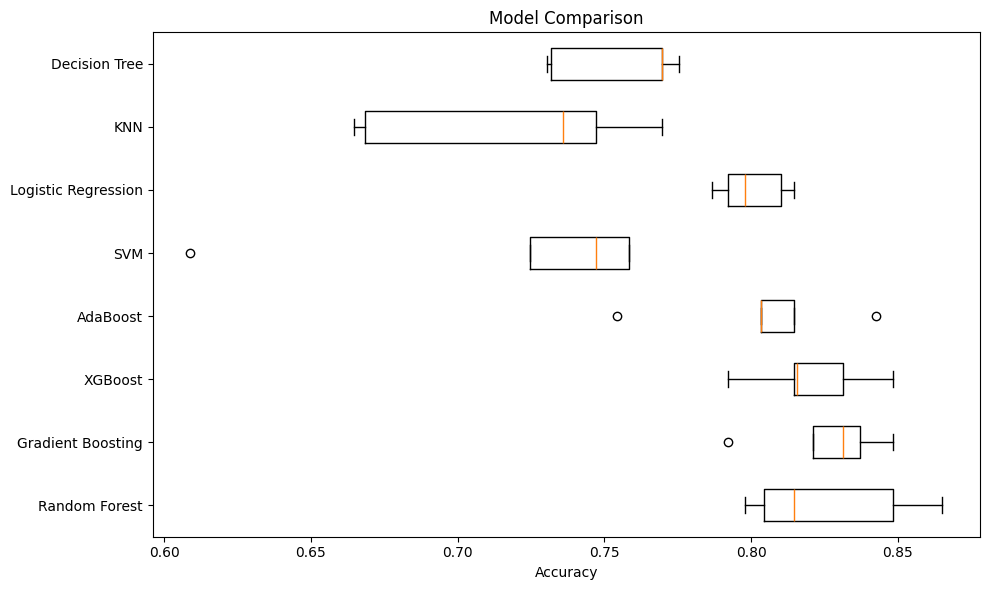


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Best cross-validation accuracy: 0.8257953314291342

Best Model Performance:
Accuracy: 0.7988826815642458

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



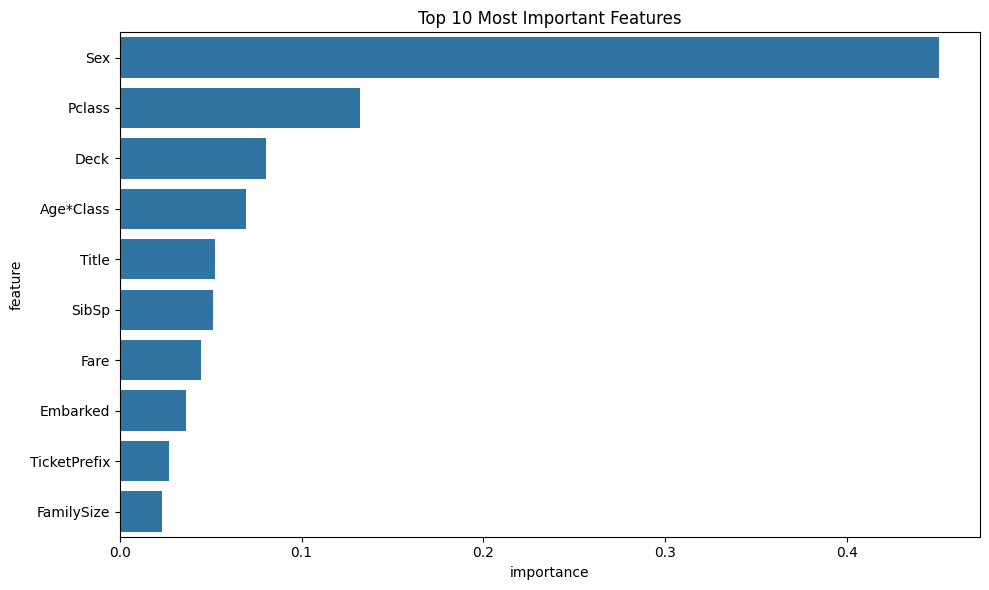

In [10]:
# Import models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Create a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Compare models using cross-validation
results = []
names = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print(f'{name} - Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, vert=False)
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

# Train the best model (example with hyperparameter tuning)
from sklearn.model_selection import GridSearchCV

# Example with XGBoost (usually performs well)
best_model = XGBClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nBest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance for the best model (if using XGBoost)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

In [11]:
# Copy the test data
test_data = test_data.copy()

# Feature engineering
test_data = feature_engineering(test_data)

# Select features for the model 
test_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
           'FamilySize', 'IsAlone', 'FareBin', 'AgeBin', 'Deck', 'NameLength',
           'TicketPrefix', 'Age*Class']
X_test = test_data[test_features]

# Make predictions
predictions = best_model.predict(X_test)

# Save predictions to a CSV file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})

# Save the submission to a CSV file
submission.to_csv('./submission.csv', index=False)